# Demystifying Decision Trees

In [5]:
import pandas as pd
import numpy as np
#from google.colab import drive
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline


In [6]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import DecisionTreeRegressor as DTR

### Get the data

In [7]:
#drive.mount('/content/drive')

In [8]:
#data = pd.read_csv('/content/drive/My Drive/data/titanic_train.csv')
data = pd.read_csv('data/titanic/train.csv')


### Let's take a look at the titanic data again, we have both categoric and numeric

In [9]:
data = data.assign(is_female = (data.Sex =='female')*1)

In [10]:
data.shape

(891, 13)

In [11]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_female
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


### Define and explore Entropy function
$ Entropy = -\sum_i p_i\log(p_i) $

In [12]:
def entropy(p):
    q = 1.0-p
    if q*p == 0:
        return 0.0 # edge case
    return max(-(p*np.log2(p) + q*np.log2(q)),0.0)

def label_to_entropy(target):
    p = target.mean()
    return entropy(p)

In [13]:
x= np.arange(0,1,10e-3)

y= [entropy(i) for i in x]

In [14]:
x

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,
        0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,
        0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,
        0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
        0.9 ,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99])

In [15]:
y

[0.0,
 0.080793135895911181,
 0.14144054254182067,
 0.1943918578315762,
 0.24229218908241482,
 0.28639695711595625,
 0.32744491915447627,
 0.36592365090022333,
 0.40217919020227277,
 0.43646981706410287,
 0.46899559358928122,
 0.499915958164528,
 0.52936086528736437,
 0.55743818502798903,
 0.58423881164285596,
 0.60984030471640038,
 0.63430955464056615,
 0.65770477874421951,
 0.68007704572827976,
 0.70147145988389736,
 0.72192809488736231,
 0.74148273993127367,
 0.76016750296196567,
 0.77801130354653769,
 0.79504027938452226,
 0.81127812445913283,
 0.82674637249261784,
 0.84146463620817569,
 0.85545081056013061,
 0.86872124633940451,
 0.8812908992306927,
 0.89317345837785678,
 0.90438145772449385,
 0.91492637277972755,
 0.92481870497303009,
 0.93406805537549098,
 0.94268318925549222,
 0.95067209268706587,
 0.95804202222629953,
 0.9647995485050872,
 0.97095059445466858,
 0.97650046875782404,
 0.98145389503365354,
 0.98581503717891972,
 0.98958752122205562,
 0.99277445398780828,
 0.99537

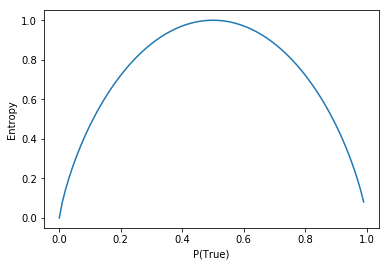

In [16]:
plt.plot(x,y)
plt.xlabel('P(True)')
plt.ylabel('Entropy');

### Calculate Entropy and the Information Gain of split by 'Sex' feature

In [17]:
p_survive = data.Survived.mean()
p_survive

0.3838383838383838

In [18]:
base_accuracy = max(p_survive,1-p_survive)
base_accuracy

0.6161616161616161

In [19]:
data.groupby(['is_female']).agg({'PassengerId':'count', 'Survived':'mean'})

,PassengerId,Survived
is_female,,
0,577,0.188908
1,314,0.742038


In [20]:
p_survive_male = data[data['is_female']==0].Survived.mean()
p_survive_female = data[data['is_female']==1].Survived.mean()
p_survive_male,p_survive_female

(0.18890814558058924, 0.7420382165605095)

In [21]:
new_accuracy = data.is_female.mean()*p_survive_female+ (1.0-data.is_female.mean())*(1.0-p_survive_male)
new_accuracy

0.7867564534231202

### Our split tree:
![title](https://i.ibb.co/6YTy9tz/titanic-survival.jpg)

$ Entropy\; H(X) = -\sum p(X)\log p(X)\\ Information\ Gain\; I(X,Y)= H(X)-H(X|Y)$

In [22]:
def info_gain(feature,split,data,target_col):
    
    p_target = data[target_col].mean() # initial target probabilty
    
    p_target_0 = data[data[feature]<split][target_col].mean() # posterior target probabilty
    p_target_1 = data[data[feature]>=split][target_col].mean() # posterior target probabilty
    
    p_feature_0 = (data[feature]<split).mean() # each split weight
    p_feature_1 = (data[feature]>=split).mean()
    
    IG =  entropy(p_target) - (p_feature_0*entropy(p_target_0) + p_feature_1*entropy(p_target_1)) # average IG
    if p_feature_0*p_feature_1==0: 
        return 0 #edge case
    else:
        return IG

In [23]:
info_gain('is_female',0.5,data,'Survived')

0.21766010666061419

### Find the best splits by Age and Fare

In [26]:
ages = sorted(data.Age.dropna().unique())
ages.append(ages[-1]+1) # adding extra splitted

In [27]:
gains_age = []
for age in ages:
    gains_age.append((info_gain('Age',age,data,'Survived')))

Best split at age 7.0 with 0.194 IG


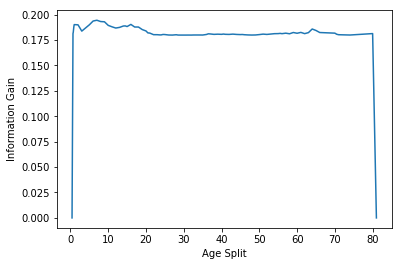

In [29]:
plt.plot(ages,gains_age)
plt.xlabel('Age Split')
plt.ylabel('Information Gain')

best_ig = max(gains_age)
best_split_age = ages[gains_age.index(best_ig)]
print('Best split at age {:.1f} with {:.3f} IG'.format(best_split_age,best_ig))

#### Check the best fare split given the best age slplit

In [30]:
fares = sorted(data.Fare.dropna().unique())
fares.append(fares[-1]+1) # adding extra splitted
gains_fare = []
for fare in fares:
    gains_fare.append((info_gain('Fare',fare,data[data.Age>best_split_age],'Survived')))

Best split at fare 52.6 with 0.085 IG


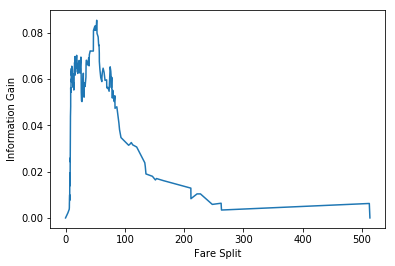

In [33]:
plt.plot(fares,gains_fare)
plt.xlabel('Fare Split')
plt.ylabel('Information Gain')

best_ig = max(gains_fare)
best_split_fare = fares[gains_fare.index(best_ig)]
print('Best split at fare {:.1f} with {:.3f} IG'.format(best_split_fare,best_ig))

In [34]:
data.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'is_female'],
      dtype='object')

In [35]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,is_female
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


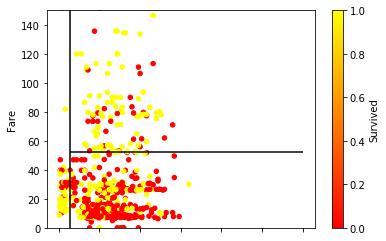

In [36]:
data.plot.scatter('Age','Fare',c = 'Survived', cmap = matplotlib.cm.autumn)
plt.ylim(0,150)
plt.vlines(best_split_age,0,150)
plt.hlines(best_split_fare,best_split_age,150)

### Train a Tree

In [37]:
features = [ 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare','is_female']
target = 'Survived'

In [38]:
only_numeric_data = data[features+[target]].dropna()

In [39]:
only_numeric_data.shape

(714, 7)

In [40]:
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(
        only_numeric_data[features],only_numeric_data[target], test_size = 0.20, random_state = 777)

data_train.shape, data_test.shape, target_train.shape, target_test.shape

((571, 6), (143, 6), (571,), (143,))

In [41]:
my_tree = DTC()
my_tree.fit(data_train,target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
train_pred = my_tree.predict(data_train)
test_pred = my_tree.predict(data_test)
train_pred_prob = my_tree.predict_proba(data_train)[:,1]
test_pred_prob = my_tree.predict_proba(data_test)[:,1]

### Check the performance on Train and Test

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [44]:
print('Train accuracy:', accuracy_score(target_train,train_pred))
print('Test accuracy:',accuracy_score(target_test,test_pred))

('Train accuracy:', 0.98423817863397545)
('Test accuracy:', 0.74825174825174823)


('Train auc:', 0.99945811551702157)
('Test auc:', 0.73975903614457827)


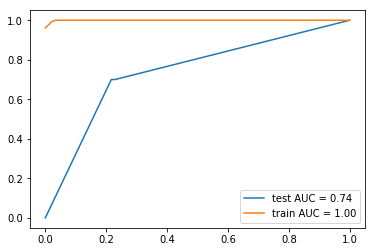

In [45]:
fpr, tpr, threshold = roc_curve(target_test, test_pred_prob)
auc_test = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'test AUC = %0.2f' % auc_test)
fpr, tpr, threshold = roc_curve(target_train, train_pred_prob)
auc_train = auc(fpr, tpr)
plt.plot(fpr, tpr , label = 'train AUC = %0.2f' % auc_train)
plt.legend();

print('Train auc:', auc_train)
print('Test auc:',auc_test)

### We have overfitting - lets do regularization

In [46]:
my_tree = DTC(max_depth = 3)
# we can also tune class_weights, split criteria,min_samples_split etc..
my_tree.fit(data_train,target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

('Train auc:', 0.88503123804666584)
('Test auc:', 0.85311244979919676)


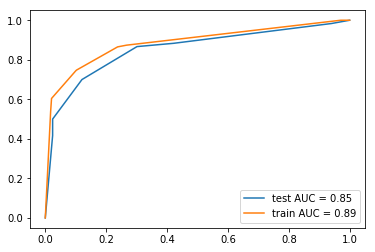

In [47]:
train_pred_prob = my_tree.predict_proba(data_train)[:,1]
test_pred_prob = my_tree.predict_proba(data_test)[:,1]

fpr, tpr, threshold = roc_curve(target_test, test_pred_prob)
auc_test = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'test AUC = %0.2f' % auc_test)
fpr, tpr, threshold = roc_curve(target_train, train_pred_prob)
auc_train = auc(fpr, tpr)
plt.plot(fpr, tpr , label = 'train AUC = %0.2f' % auc_train)
plt.legend();

print('Train auc:', auc_train)
print('Test auc:',auc_test)

### Check Features Importance

In [48]:
my_tree.feature_importances_

array([ 0.19802359,  0.06381656,  0.07618155,  0.        ,  0.01982587,
        0.64215243])

<Container object of 6 artists>

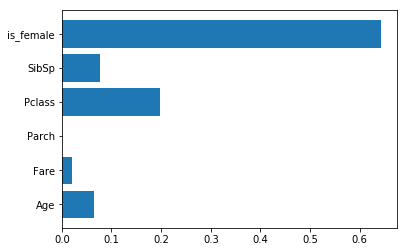

In [49]:
plt.barh(features,my_tree.feature_importances_)

### Check the tree

In [50]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    # https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print "def tree({}):".format(", ".join(feature_names))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print "{}if {} <= {}:".format(indent, name, threshold)
            recurse(tree_.children_left[node], depth + 1)
            print "{}else:  # if {} > {}".format(indent, name, threshold)
            recurse(tree_.children_right[node], depth + 1)
        else:
            print "{}return {}".format(indent, tree_.value[node])

    recurse(0, 1)

In [51]:
def tree_to_code_list(tree, feature_names):
    # https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print "def tree({}):".format(", ".join(feature_names))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print "{}if {} <= {}:".format(indent, name, threshold)
            recurse(tree_.children_left[node], depth + 1)
            print "{}else:  # if {} > {}".format(indent, name, threshold)
            recurse(tree_.children_right[node], depth + 1)
        else:
            print "{}return {}".format(indent, tree_.value[node])

    recurse(0, 1)

In [52]:
tree_to_code(my_tree,features)

def tree(Pclass, Age, SibSp, Parch, Fare, is_female):
  if is_female <= 0.5:
    if Age <= 13.0:
      if SibSp <= 2.0:
        return [[  1.  15.]]
      else:  # if SibSp > 2.0
        return [[ 10.   0.]]
    else:  # if Age > 13.0
      if Pclass <= 1.5:
        return [[ 46.  27.]]
      else:  # if Pclass > 1.5
        return [[ 240.   29.]]
  else:  # if is_female > 0.5
    if Pclass <= 2.5:
      if Age <= 2.5:
        return [[ 1.  1.]]
      else:  # if Age > 2.5
        return [[   6.  124.]]
    else:  # if Pclass > 2.5
      if Fare <= 20.7999992371:
        return [[ 27.  32.]]
      else:  # if Fare > 20.7999992371
        return [[ 10.   2.]]


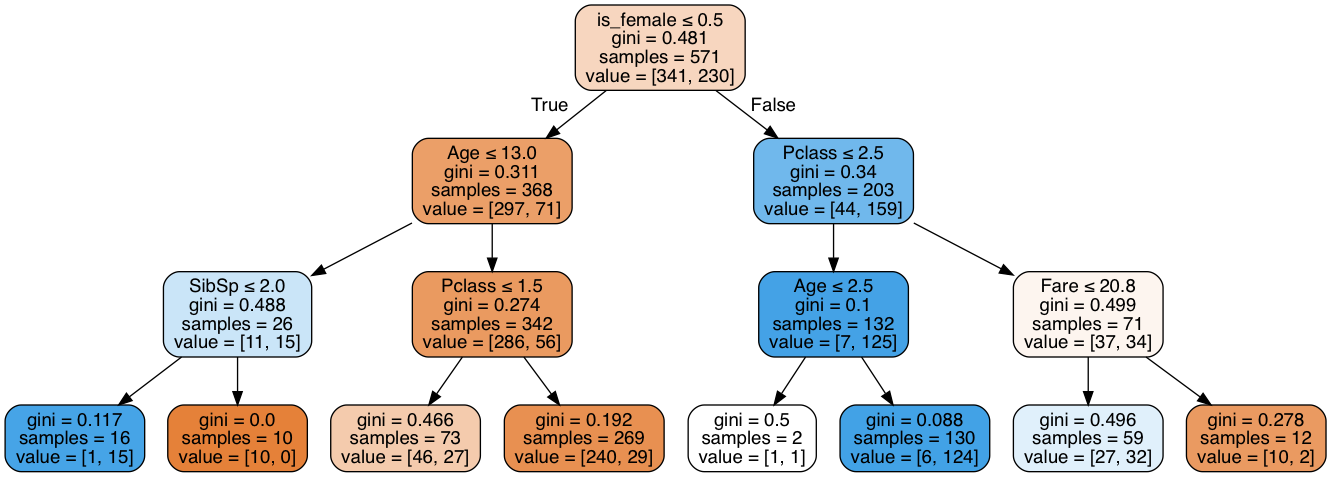

In [53]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from StringIO import StringIO
dot_data = StringIO()

export_graphviz(my_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=features)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())